Please upload your weather CSV file:


Saving 三重_2020.csv to 三重_2020.csv
Dataset loaded: 4762 rows, 28 columns

First few rows:
   測站                   日期        測項    00    01    02    03    04    05  \
0  三重  2020/01/01 00:00:00  AMB_TEMP  15.6  15.7  15.6  15.5  15.4  15.6   
1  三重  2020/01/01 00:00:00       CH4  1.83  1.83  1.84   1.8   1.8   1.8   
2  三重  2020/01/01 00:00:00        CO  0.61  0.73  0.56  0.43  0.39  0.46   
3  三重  2020/01/01 00:00:00      NMHC  0.17  0.16  0.12  0.09  0.09   0.1   
4  三重  2020/01/01 00:00:00        NO  23.4  18.8  16.2   9.8   9.8  28.3   

     06  ...    15    16    17    18    19    20    21    22    23 Unnamed: 27  
0  15.7  ...  17.9  17.4  16.9  16.9    17  17.3  17.5  17.6  17.9         NaN  
1   1.8  ...  1.82  1.79  1.86  1.84  1.82  1.88  1.82  1.88  1.84         NaN  
2  0.62  ...  1.02  0.88  1.33  1.23  0.99  1.15  1.03  1.06  0.88         NaN  
3  0.16  ...  0.29  0.26  0.38  0.37  0.28  0.33  0.27  0.27   0.2         NaN  
4  27.8  ...  36.7    31  50.3  48.8  41.9  44.6 

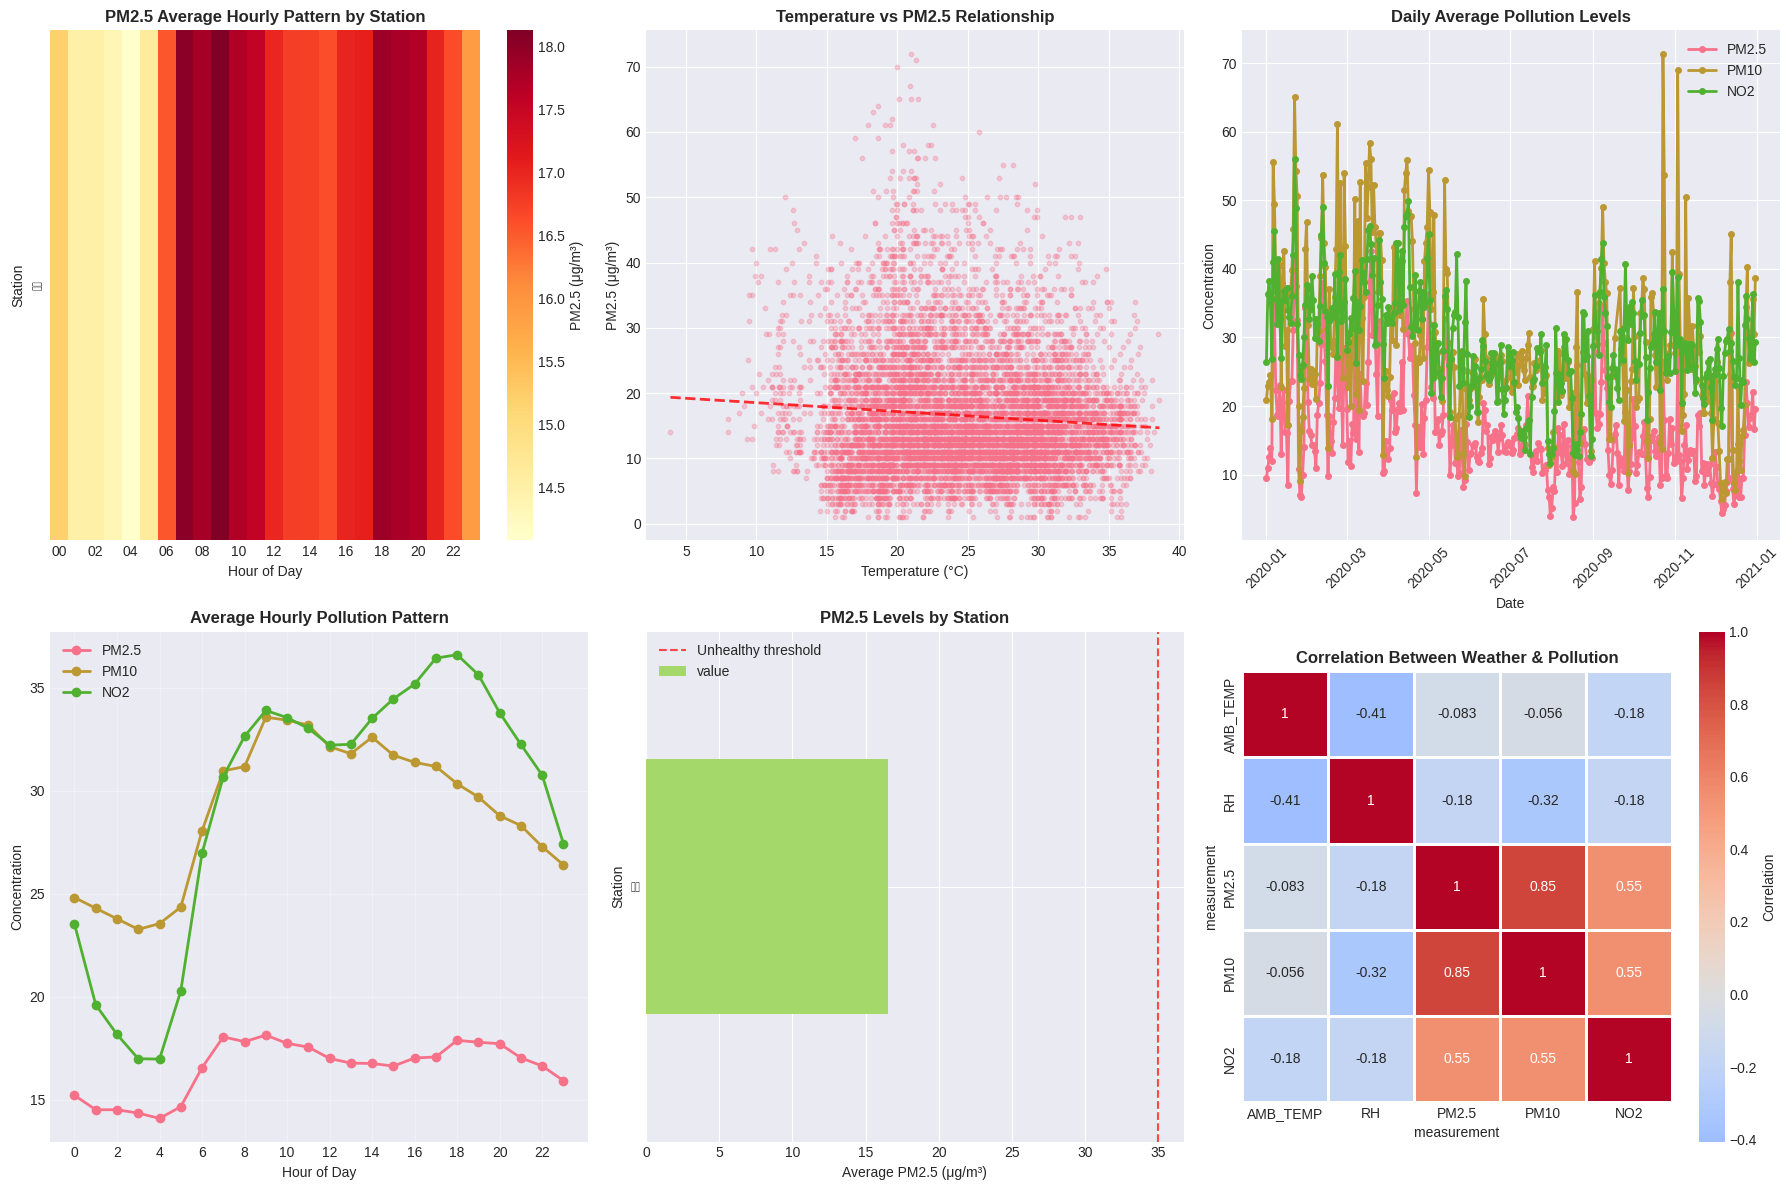


VISUALIZATIONS GENERATED

KEY FINDINGS & INSIGHTS

1. Peak PM2.5 Hour: 09:00 (Average: 18.12 μg/m³)
   Likely due to morning/evening traffic or atmospheric conditions

2. Temperature-PM2.5 Correlation: -0.083

3. Station Comparison:
   Cleanest: 三重 (Avg PM2.5: 16.55 μg/m³)
   Most Polluted: 三重 (Avg PM2.5: 16.55 μg/m³)

4. Health Impact:
   4.8% of hours exceed PM2.5 healthy threshold (35 μg/m³)

ANALYSIS COMPLETE!

Next Steps:
1. Upload this notebook to GitHub
2. Create a GitHub Page for public access
3. Record a 1-minute video presentation or write a summary
4. Consider time-series forecasting for future work


In [1]:
# Weather Data Analysis: Air Quality and Temperature Patterns in Taiwan
# Objective: Analyze temporal patterns in air quality metrics and identify relationships between weather conditions and pollution levels

# ============================================
# 1. OBJECTIVES
# ============================================
"""
Main Objectives:
1. Analyze hourly patterns of air pollutants (PM2.5, PM10, NO2, CO) across different stations
2. Investigate the relationship between temperature/humidity and air quality
3. Identify peak pollution hours and potential contributing factors
4. Visualize trends and provide insights for public health awareness
"""

# ============================================
# 2. PSEUDOCODE & FLOWCHART DESCRIPTION
# ============================================
"""
PSEUDOCODE:
1. Load and inspect the weather CSV data
2. Transform data structure:
   - Melt hourly columns (00-23) into long format
   - Parse datetime information
   - Clean missing values and data types
3. Calculate summary statistics for each measurement type
4. Create visualizations:
   - Time series plots for pollution levels
   - Heatmaps showing hourly patterns
   - Correlation analysis between variables
   - Station comparison charts
5. Extract insights and document findings

FLOWCHART LOGIC:
Start → Load CSV → Data Validation → Transform to Long Format →
Clean Data → Calculate Statistics → Generate Visualizations →
Analyze Patterns → Document Insights → End
"""

# ============================================
# 3. IMPLEMENTATION - ALGORITHMS
# ============================================

# Install and import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================
# STEP 1: Data Loading and Initial Inspection
# ============================================

# Upload your CSV file in Google Colab
from google.colab import files
print("Please upload your weather CSV file:")
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Load the data
df_raw = pd.read_csv(filename, encoding='utf-8')
print(f"Dataset loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
print("\nFirst few rows:")
print(df_raw.head())
print("\nColumn names:")
print(df_raw.columns.tolist())

# ============================================
# STEP 2: Data Transformation Algorithm
# ============================================

def transform_weather_data(df):
    """
    Transform wide-format hourly data into long format for analysis

    Algorithm:
    1. Identify hour columns (00-23)
    2. Use pd.melt to pivot hourly values into rows
    3. Create proper datetime column
    4. Convert numeric columns to float type
    """
    # Identify hour columns
    hour_cols = [col for col in df.columns if col.isdigit() and len(col) <= 2]
    id_cols = ['測站', '日期', '測項']

    # Melt the dataframe
    df_long = pd.melt(
        df,
        id_vars=id_cols,
        value_vars=hour_cols,
        var_name='hour',
        value_name='value'
    )

    # Create datetime column
    df_long['datetime'] = pd.to_datetime(df_long['日期']) + pd.to_timedelta(df_long['hour'].astype(int), unit='h')

    # Convert value to numeric
    df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')

    # Rename columns to English for easier processing
    df_long = df_long.rename(columns={
        '測站': 'station',
        '日期': 'date',
        '測項': 'measurement'
    })

    return df_long

# Apply transformation
df_long = transform_weather_data(df_raw)
print(f"\nTransformed data shape: {df_long.shape}")
print(df_long.head(10))

# ============================================
# STEP 3: Data Cleaning and Preparation
# ============================================

# Remove rows with missing values
df_clean = df_long.dropna(subset=['value'])

# Get unique measurements and stations
measurements = df_clean['measurement'].unique()
stations = df_clean['station'].unique()

print(f"\nStations: {stations}")
print(f"Measurements: {measurements}")
print(f"\nData date range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")

# ============================================
# STEP 4: Statistical Analysis Algorithm
# ============================================

def calculate_statistics(df, measurement_type):
    """
    Calculate summary statistics for a specific measurement
    """
    data = df[df['measurement'] == measurement_type]['value']
    stats = {
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats

# Calculate statistics for key pollutants
pollutants = ['PM2.5', 'PM10', 'NO2', 'CO']
stats_summary = {}

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

for pollutant in pollutants:
    if pollutant in measurements:
        stats = calculate_statistics(df_clean, pollutant)
        stats_summary[pollutant] = stats
        print(f"\n{pollutant}:")
        print(f"  Mean: {stats['mean']:.2f}")
        print(f"  Median: {stats['median']:.2f}")
        print(f"  Std Dev: {stats['std']:.2f}")
        print(f"  Range: [{stats['min']:.2f}, {stats['max']:.2f}]")

# ============================================
# 4. VISUALIZATIONS
# ============================================

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# Visualization 1: Hourly Pattern Heatmap for PM2.5
plt.subplot(2, 3, 1)
pm25_data = df_clean[df_clean['measurement'] == 'PM2.5'].copy()
if not pm25_data.empty:
    pm25_pivot = pm25_data.groupby(['station', 'hour'])['value'].mean().reset_index()
    pm25_heatmap = pm25_pivot.pivot(index='station', columns='hour', values='value')
    sns.heatmap(pm25_heatmap, cmap='YlOrRd', annot=False, fmt='.1f', cbar_kws={'label': 'PM2.5 (μg/m³)'})
    plt.title('PM2.5 Average Hourly Pattern by Station', fontsize=12, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Station')

# Visualization 2: Temperature vs PM2.5 Scatter
plt.subplot(2, 3, 2)
temp_data = df_clean[df_clean['measurement'] == 'AMB_TEMP'][['datetime', 'station', 'value']].rename(columns={'value': 'temperature'})
pm25_data = df_clean[df_clean['measurement'] == 'PM2.5'][['datetime', 'station', 'value']].rename(columns={'value': 'pm25'})
merged = pd.merge(temp_data, pm25_data, on=['datetime', 'station'])
if not merged.empty:
    plt.scatter(merged['temperature'], merged['pm25'], alpha=0.3, s=10)
    plt.xlabel('Temperature (°C)')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.title('Temperature vs PM2.5 Relationship', fontsize=12, fontweight='bold')
    z = np.polyfit(merged['temperature'].dropna(), merged['pm25'].dropna(), 1)
    p = np.poly1d(z)
    plt.plot(merged['temperature'].sort_values(), p(merged['temperature'].sort_values()), "r--", alpha=0.8, linewidth=2)

# Visualization 3: Daily Average Pollution Levels
plt.subplot(2, 3, 3)
pollutant_data = df_clean[df_clean['measurement'].isin(['PM2.5', 'PM10', 'NO2'])]
daily_avg = pollutant_data.groupby([pollutant_data['datetime'].dt.date, 'measurement'])['value'].mean().reset_index()
daily_avg.columns = ['date', 'measurement', 'value']
for pollutant in ['PM2.5', 'PM10', 'NO2']:
    data = daily_avg[daily_avg['measurement'] == pollutant]
    if not data.empty:
        plt.plot(data['date'], data['value'], marker='o', label=pollutant, linewidth=2, markersize=4)
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.title('Daily Average Pollution Levels', fontsize=12, fontweight='bold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Visualization 4: Hourly Pattern for Multiple Pollutants
plt.subplot(2, 3, 4)
hourly_pattern = df_clean[df_clean['measurement'].isin(['PM2.5', 'PM10', 'NO2', 'CO'])]
hourly_avg = hourly_pattern.groupby(['hour', 'measurement'])['value'].mean().reset_index()
for pollutant in ['PM2.5', 'PM10', 'NO2']:
    data = hourly_avg[hourly_avg['measurement'] == pollutant]
    if not data.empty:
        plt.plot(data['hour'].astype(int), data['value'], marker='o', label=pollutant, linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Concentration')
plt.title('Average Hourly Pollution Pattern', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Visualization 5: Station Comparison
plt.subplot(2, 3, 5)
station_avg = df_clean[df_clean['measurement'] == 'PM2.5'].groupby('station')['value'].mean().sort_values()
if not station_avg.empty:
    colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(station_avg)))
    station_avg.plot(kind='barh', color=colors)
    plt.xlabel('Average PM2.5 (μg/m³)')
    plt.ylabel('Station')
    plt.title('PM2.5 Levels by Station', fontsize=12, fontweight='bold')
    plt.axvline(x=35, color='red', linestyle='--', label='Unhealthy threshold', alpha=0.7)
    plt.legend()

# Visualization 6: Correlation Matrix
plt.subplot(2, 3, 6)
key_measurements = ['AMB_TEMP', 'RH', 'PM2.5', 'PM10', 'NO2']
pivot_data = df_clean[df_clean['measurement'].isin(key_measurements)].pivot_table(
    index=['datetime', 'station'],
    columns='measurement',
    values='value'
).reset_index()
corr_matrix = pivot_data[key_measurements].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True,
            linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Between Weather & Pollution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('weather_analysis_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("VISUALIZATIONS GENERATED")
print("="*60)

# ============================================
# 5. KEY INSIGHTS AND FINDINGS
# ============================================

print("\n" + "="*60)
print("KEY FINDINGS & INSIGHTS")
print("="*60)

# Finding 1: Peak pollution hours
pm25_hourly = df_clean[df_clean['measurement'] == 'PM2.5'].groupby('hour')['value'].mean()
peak_hour = pm25_hourly.idxmax()
print(f"\n1. Peak PM2.5 Hour: {peak_hour}:00 (Average: {pm25_hourly.max():.2f} μg/m³)")
print(f"   Likely due to morning/evening traffic or atmospheric conditions")

# Finding 2: Temperature correlation
if not merged.empty:
    correlation = merged['temperature'].corr(merged['pm25'])
    print(f"\n2. Temperature-PM2.5 Correlation: {correlation:.3f}")
    if correlation < -0.1:
        print(f"   Negative correlation suggests higher temperatures may help disperse pollutants")
    elif correlation > 0.1:
        print(f"   Positive correlation suggests complex relationship with other factors")

# Finding 3: Station comparison
if not station_avg.empty:
    cleanest = station_avg.idxmin()
    most_polluted = station_avg.idxmax()
    print(f"\n3. Station Comparison:")
    print(f"   Cleanest: {cleanest} (Avg PM2.5: {station_avg.min():.2f} μg/m³)")
    print(f"   Most Polluted: {most_polluted} (Avg PM2.5: {station_avg.max():.2f} μg/m³)")

# Finding 4: Health implications
pm25_unhealthy = (df_clean[df_clean['measurement'] == 'PM2.5']['value'] > 35).sum()
pm25_total = (df_clean[df_clean['measurement'] == 'PM2.5'].shape[0])
unhealthy_pct = (pm25_unhealthy / pm25_total * 100)
print(f"\n4. Health Impact:")
print(f"   {unhealthy_pct:.1f}% of hours exceed PM2.5 healthy threshold (35 μg/m³)")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nNext Steps:")
